In [1]:
%autoreload 2

In [69]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 6172feb1665491d1efbce164-0
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 5f77754ba932fb2c4ba181d8-2
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 614b603d4da88384282967a7-3
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 5bc79f652885710001a0e82a-5
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 614dec67f6eb129c3a77defd-6
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 615b40bb6cdb0f1f6f291f45-8
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 615452aaabb932ada88ef3ca-9
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 57aa430b4cda6e00018420e9-10
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 5d29412ab711e9001ab74ece-11
2023-05-09 10:36:30 - ast_utils - DEBUG    - Game not found in cache: 613bb29f16252362f4dc11a3-12
2023-05-09 10:36:30 - ast_u

In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,0,...,0.975856,0.984382,0.970248,0.981414,0.981920,0.983617,0.919078,0.915602,0.974574,0.987096
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,0,...,0.985632,0.986181,0.966645,0.978594,0.977472,0.984273,0.921563,0.931860,0.945369,0.962067
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,1,...,0.975984,0.980604,0.000000,0.000000,0.000000,0.000000,0.844787,0.858832,0.923039,0.942307
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,1,...,0.986042,0.985931,0.000000,0.000000,0.000000,0.000000,0.919078,0.915602,0.974574,0.987096
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0,...,0.984624,0.983172,0.000000,0.000000,0.000000,0.000000,0.976741,0.978090,0.970715,0.987147


In [62]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [103]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        results_by_feature_count[count_set_bits(key)].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [104]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)


def plot_sampler_fitness_trajectory(evo: PopulationBasedSampler, title: typing.Optional[str] = None, axsize: typing.Tuple[int, int] = (8, 6),
                                    plot_metrics: typing.Optional[bool] = None, subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
                                    min_real_game_fitness: float = 72.8545, max_real_game_fitness: float = 78.0885):
    
    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys()}
        for step_dict in evo.archive_metrics_history:
            for key, value in step_dict.items():
                metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

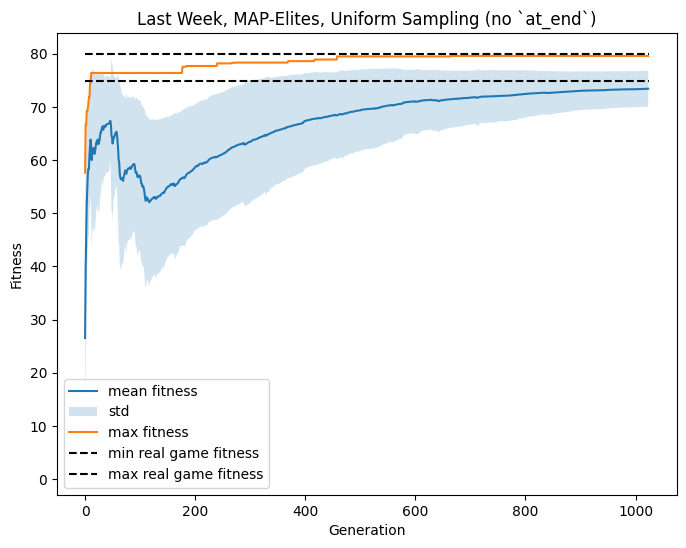

98 254


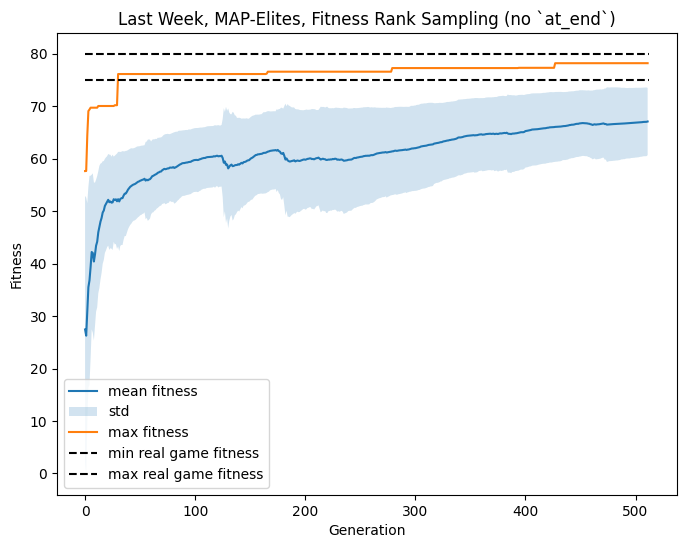

## Archive fullness analysis

Ttoal of 254 samples in archive, 13 features

### Results by feature

- compositionality_structure_0:
    - =0: 73.779 ± 3.255 (n=128)
    - =1: 73.087 ± 3.399 (n=126)
- compositionality_structure_1:
    - =0: 73.605 ± 3.261 (n=128)
    - =1: 73.265 ± 3.421 (n=126)
- compositionality_structure_2:
    - =0: 74.594 ± 3.266 (n=127)
    - =1: 72.278 ± 3.006 (n=127)
- compositionality_structure_3:
    - =0: 74.581 ± 3.183 (n=128)
    - =1: 72.272 ± 3.096 (n=126)
- compositionality_structure_4:
    - =0: 75.117 ± 2.455 (n=128)
    - =1: 71.728 ± 3.264 (n=126)
- compositionality_structure_5:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_6:
    - =0: 73.641 ± 3.273 (n=128)
    - =1: 73.228 ± 3.405 (n=126)
- compositionality_structure_7:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_8:
    - =0: 75.050 ± 2.550 (n=128)
    - =1: 71.796 ± 3.259 (n=126)
- compositionality_structure_9:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_10:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_11:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_12:
    - =0: 74.411 ± 3.149 (n=128)
    - =1: 72.445 ± 3.246 (n=126)

### Results by set feature count

- set-count=0: 78.007 ± 0.000 (n=1 / 1)
- set-count=1: 77.741 ± 0.973 (n=8 / 13)
- set-count=2: 76.994 ± 1.550 (n=28 / 78)
- set-count=3: 75.694 ± 1.963 (n=56 / 286)
- set-count=4: 73.709 ± 2.248 (n=70 / 715)
- set-count=5: 71.236 ± 2.139 (n=56 / 1287)
- set-count=6: 69.096 ± 1.860 (n=28 / 1716)
- set-count=7: 67.788 ± 1.163 (n=7 / 1716)

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


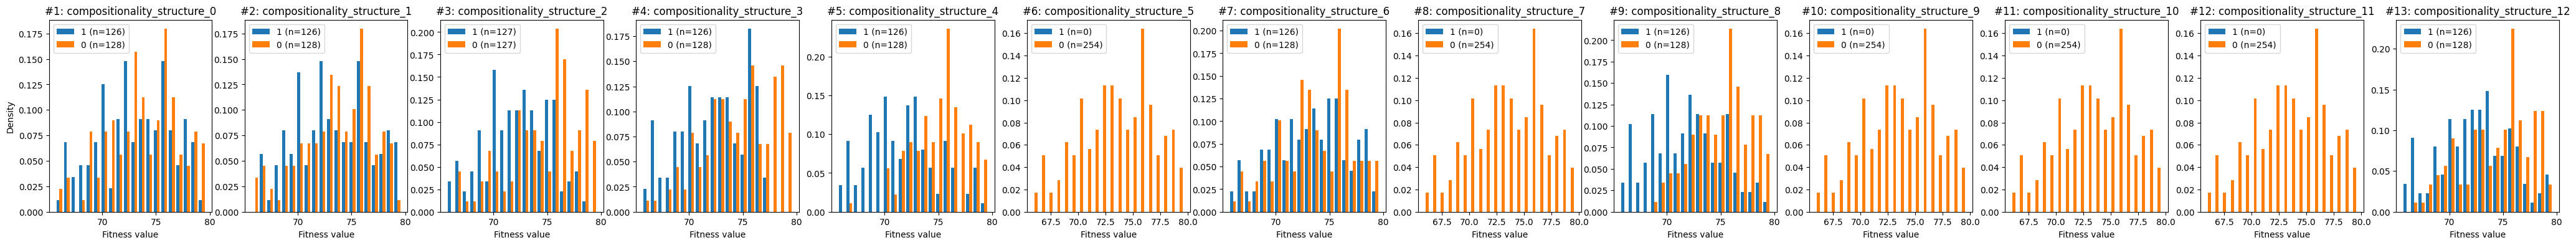

In [105]:
original_uniform = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'b726ded1_map_elites_uniform_final'))
plot_sampler_fitness_trajectory(original_uniform, 'Last Week, MAP-Elites, Uniform Sampling (no `at_end`)',
                                min_real_game_fitness=74.9304, max_real_game_fitness=80.0098)

print(count_games_above_fitness_threshold(original_uniform, 74.9304), len(original_uniform.fitness_values))

original_fitness_rank = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'b726ded1_map_elites_fitness_rank_final'))
plot_sampler_fitness_trajectory(original_fitness_rank, 'Last Week, MAP-Elites, Fitness Rank Sampling (no `at_end`)',
                                min_real_game_fitness=74.9304, max_real_game_fitness=80.0098)

analyze_archive_fullness(original_uniform)

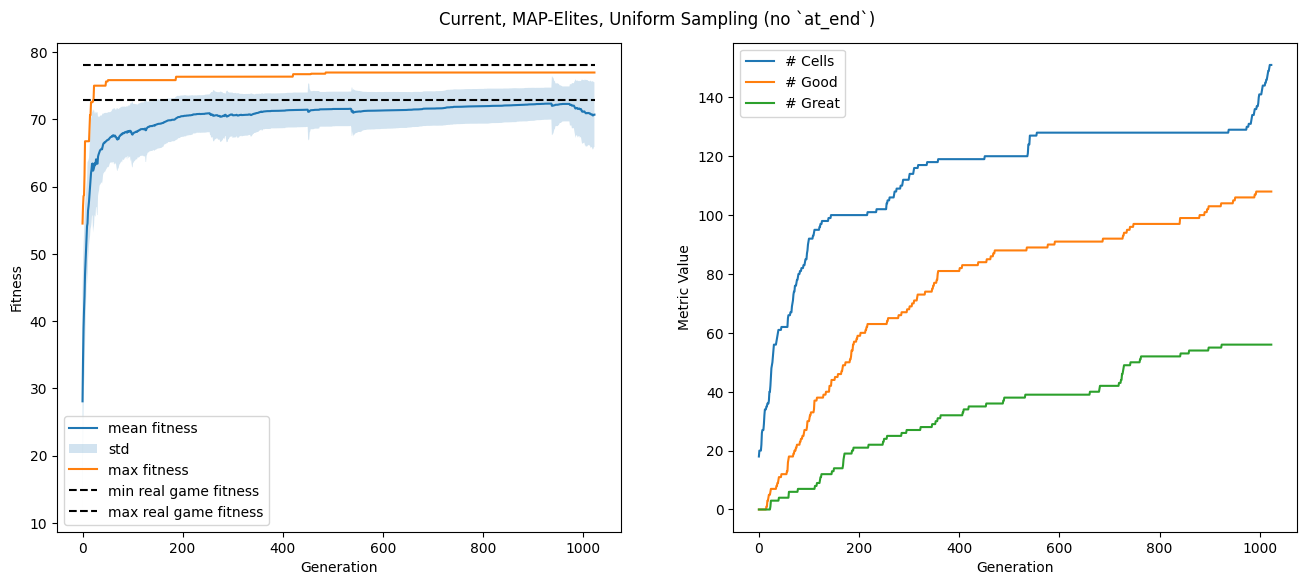

59 151


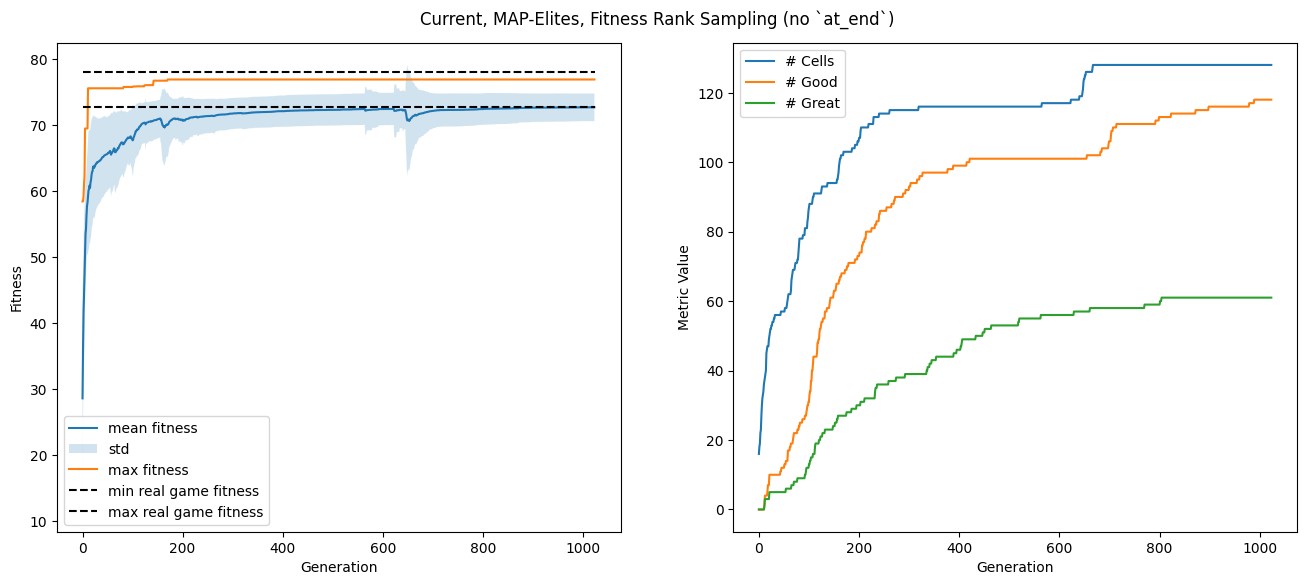

## Archive fullness analysis

Ttoal of 151 samples in archive, 10 features

### Results by feature

- compositionality_structure_0:
    - =0: 68.866 ± 5.306 (n=87)
    - =1: 73.203 ± 2.385 (n=64)
- compositionality_structure_1:
    - =0: 69.489 ± 5.701 (n=87)
    - =1: 72.356 ± 2.427 (n=64)
- compositionality_structure_2:
    - =0: 71.400 ± 5.195 (n=77)
    - =1: 69.980 ± 4.276 (n=74)
- compositionality_structure_3:
    - =0: 70.814 ± 5.672 (n=80)
    - =1: 70.580 ± 3.622 (n=71)
- compositionality_structure_4:
    - =0: 70.242 ± 5.549 (n=85)
    - =1: 71.300 ± 3.585 (n=66)
- compositionality_structure_5:
    - =0: 71.103 ± 4.554 (n=144)
    - =1: 62.506 ± 1.968 (n=7)
- compositionality_structure_6:
    - =0: 69.827 ± 5.773 (n=85)
    - =1: 71.833 ± 2.821 (n=66)
- compositionality_structure_7:
    - =0: 71.047 ± 5.296 (n=79)
    - =1: 70.328 ± 4.203 (n=72)
- compositionality_structure_8:
    - =0: 71.235 ± 4.227 (n=144)
    - =1: 59.786 ± 2.922 (n=7)
- compositionality_structure_9:
    - =0: 71.369 ± 4.114 (n=142)
    - =1: 60.213 ± 2.378 (n=9)

### Results by set feature count

- set-count=0: 73.163 ± 0.000 (n=1 / 1)
- set-count=1: 70.461 ± 6.088 (n=10 / 10)
- set-count=2: 69.585 ± 6.528 (n=32 / 45)
- set-count=3: 70.468 ± 5.673 (n=44 / 120)
- set-count=4: 72.041 ± 1.891 (n=35 / 210)
- set-count=5: 71.353 ± 1.804 (n=21 / 252)
- set-count=6: 69.075 ± 1.522 (n=7 / 210)
- set-count=7: 67.859 ± 0.000 (n=1 / 120)

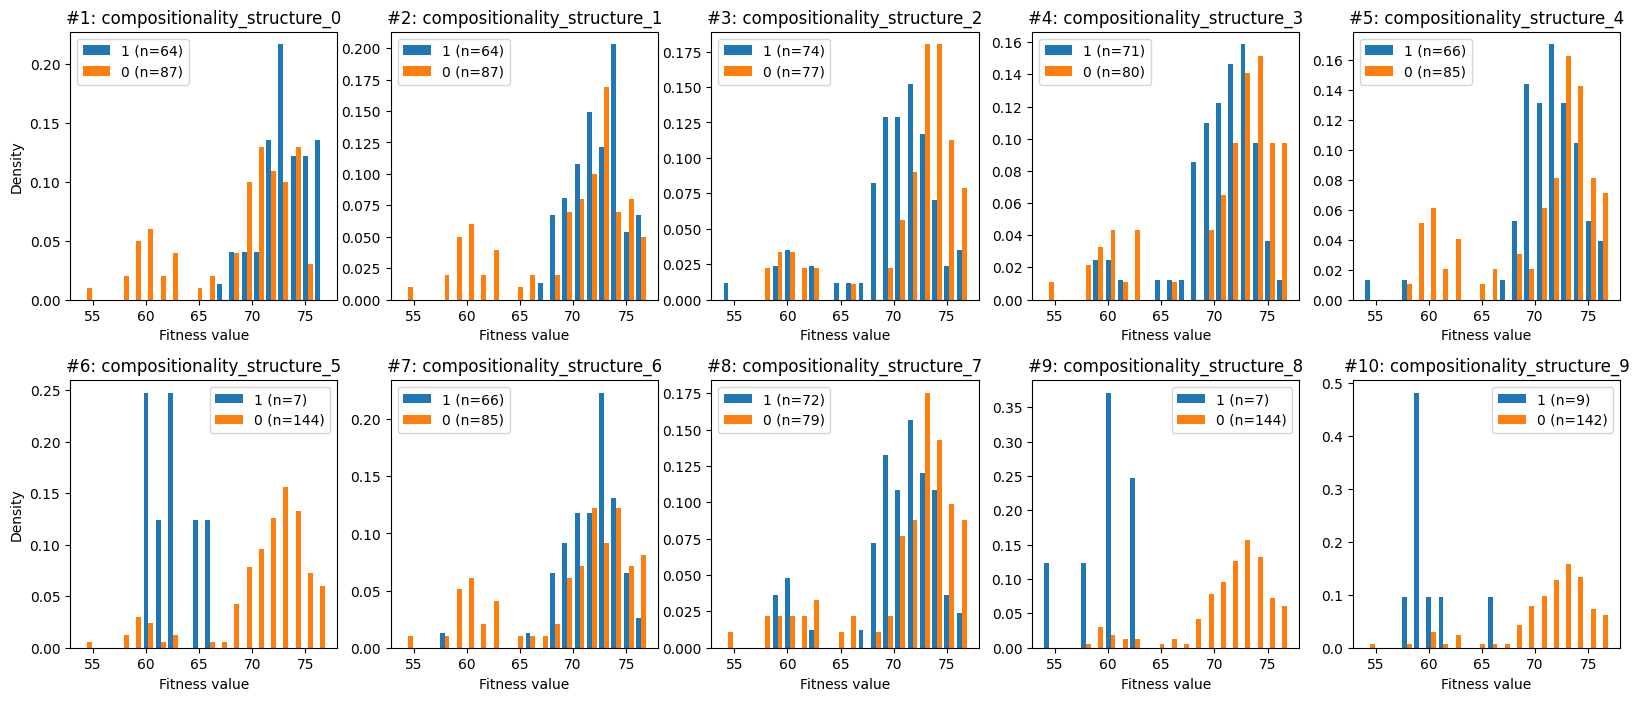

In [99]:
current_uniform = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'evo_sampler_map_elites_uniform_compositionality_final'))
plot_sampler_fitness_trajectory(current_uniform, 'Current, MAP-Elites, Uniform Sampling (no `at_end`)')

print(count_games_above_fitness_threshold(current_uniform, 72.8545), len(current_uniform.fitness_values))

current_fitness_rank = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'evo_sampler_map_elites_fitness_rank_compositionality_final'))
plot_sampler_fitness_trajectory(current_fitness_rank, 'Current, MAP-Elites, Fitness Rank Sampling (no `at_end`)')

analyze_archive_fullness(current_uniform)

In [52]:
98/254

0.3858267716535433

In [ ]:
evo_sampler_map_elites_ucb = typing.cast(MAPElitesSampler, utils.load_data('2023_05_08', 'samples', 'evo_sampler_map_elites_ucb_2_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_ucb, 'MAP-Elites, UCB Sampling')

In [ ]:
evo_sampler_map_elites_ucb_resume = typing.cast(MAPElitesSampler, utils.load_data('2023_05_08', 'samples', 'evo_sampler_map_elites_ucb_2_resume_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_ucb_resume, 'MAP-Elites, UCB Sampling')

In [ ]:
evo_sampler_map_elites_thompson_no_at_end = typing.cast(MAPElitesSampler, utils.load_data('2023_05_05', 'samples', 'evo_sampler_map_elites_thompson_from_fitness_rank_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_thompson_no_at_end, 'MAP-Elites, Thompson Sampling (no `at_end`)')

In [ ]:
evo_sampler_map_elites_fitness_rank_no_at_end = typing.cast(MAPElitesSampler, utils.load_data('2023_05_05', 'samples', 'evo_sampler_map_elites_fitness_rank_resume_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_fitness_rank_no_at_end, 'MAP-Elites, Fitness Rank Sampling (no `at_end`)')

In [31]:
def visualize_sample_from_old_model(
    old_model: MAPElitesSampler, new_model: MAPElitesSampler, top_index: int, 
    sample_features: typing.Optional[typing.Dict[str, int]] = None,
    n_features_on: typing.Optional[int] = None,
    feature_keywords_to_print: typing.Optional[typing.List[str]] = None,
    n_similar_real_games_to_print: int = 3
    ):

    old_model_index_key = old_model.top_sample_key(top_index, sample_features, n_features_on)
    key_dict = {f: (old_model_index_key >> i) % 2 for i, f in enumerate(old_model.map_elites_feature_names)}
    print(f'Sample features for key {old_model_index_key}:')
    for feature_name, feature_value in key_dict.items():
        print(f'{feature_name}: {feature_value}')

    old_model_index_game = old_model.population[old_model_index_key]

    new_model._visualize_sample(old_model_index_game, feature_keywords_to_print=feature_keywords_to_print)
    print_nearest_real_games(old_model_index_game, n_similar_real_games_to_print)



In [55]:
visualize_sample_from_old_model(original_uniform, current_uniform, 3)

Sample features for key 258:
compositionality_structure_0: 0
compositionality_structure_1: 1
compositionality_structure_2: 0
compositionality_structure_3: 0
compositionality_structure_4: 0
compositionality_structure_5: 0
compositionality_structure_6: 0
compositionality_structure_7: 0
compositionality_structure_8: 1
compositionality_structure_9: 0
compositionality_structure_10: 0
compositionality_structure_11: 0
compositionality_structure_12: 0


### Energy of visualized game: -71.805

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                              |
|----------------------------------------------------------------------------|-----------------------------------------------------------------------|
| agent_holds_arg_types_balls_constraints: **1.209** = (1.000) * 1.209       | ast_ngram_full_n_7_score: **-23.352** = (0.853) * -27.378             |
| max_depth_scoring_1: **0.920** = (1.000) * 0.920                           | ast_ngram_constraints_n_7_score: **-17.452** = (0.877) * -19.900      |
| node_count_constraints_1: **0.722** = (1.000) * 0.722                      | all_variables_used: **-5.012** = (1.000) * -5.012                     |
| mean_depth_constraints_2: **0.714** = (1.000) * 0.714                      | all_preferences_used: **-4.458** = (1.000) * -4.458                   |
| predicate_under_modal_once_in: **0.649** = (1.000) * 0.649                 | ast_ngram_scoring_n_5_score: **-3.826** = (0.987) * -3.876            |
| node_count_scoring_0: **0.319** = (1.000) * 0.319                          | all_variables_defined: **-2.057** = (1.000) * -2.057                  |
| compositionality_structure_4: **0.301** = (1.000) * 0.301                  | section_doesnt_exist_setup: **-2.032** = (1.000) * -2.032             |
| length_of_then_modals_3: **0.273** = (1.000) * 0.273                       | node_count_setup_0: **-1.900** = (1.000) * -1.900                     |
| max_number_variables_types_quantified_types_1: **0.255** = (1.000) * 0.255 | max_depth_setup_0: **-1.802** = (1.000) * -1.802                      |
| starts_and_ends_once: **0.082** = (1.000) * 0.082                          | mean_depth_setup_0: **-1.799** = (1.000) * -1.799                     |
|                                                                            | num_preferences_defined_1: **-1.324** = (1.000) * -1.324              |
|                                                                            | predicate_under_modal_once_adjacent: **-1.094** = (1.000) * -1.094    |
|                                                                            | max_quantification_count_setup_0: **-1.087** = (1.000) * -1.087       |
|                                                                            | mean_depth_scoring_1: **-1.054** = (1.000) * -1.054                   |
|                                                                            | predicate_under_modal_once_agent_holds: **-0.974** = (1.000) * -0.974 |
|                                                                            | section_doesnt_exist_terminal: **-0.860** = (1.000) * -0.860          |
|                                                                            | mean_depth_terminal_0: **-0.834** = (1.000) * -0.834                  |
|                                                                            | node_count_terminal_0: **-0.794** = (1.000) * -0.794                  |
|                                                                            | compositionality_structure_0: **-0.792** = (1.000) * -0.792           |
|                                                                            | max_depth_terminal_0: **-0.782** = (1.000) * -0.782                   |

### Game:

```pddl
(define (game evo-716-385-0) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - dodgeball ?v1 - hexagonal_bin ?v2 - pillow)
        (then
          (once (and (adjacent ?v2 agent) (agent_holds ?v0) ) )
          (hold (and (in_motion ?v0) (not (agent_holds ?v0) ) ) )
          (once (and (not (in_motion ?v0) ) (in ?v1 ?v0) ) )
        )
      )
    )
  )
)
(:scoring
  (count preference0)
)
)
```

### Nearest real game #1:

Edit distance to sample 118, real game nearest neighbor distances [26, 28, 58]):


```pddl
(define (game 60a6ba026f8bd75b67b23c97-93) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference throwBallToBin
      (exists (?d - dodgeball ?h - hexagonal_bin)
        (then
          (once (agent_holds ?d) )
          (hold (and (not (agent_holds ?d) ) (in_motion ?d) ) )
          (once (and (not (in_motion ?d) ) (in ?h ?d) ) )
        )
      )
    )
  )
)
(:scoring
  (count throwBallToBin)
)
)
```

### Nearest real game #2:

Edit distance to sample 118, real game nearest neighbor distances [26, 28, 56]):


```pddl
(define (game 5ff4a242cbe069bc27d9278b-51) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference throwToBin
      (exists (?d - dodgeball ?h - hexagonal_bin)
        (then
          (once (agent_holds ?d) )
          (hold (and (not (agent_holds ?d) ) (in_motion ?d) ) )
          (once (and (not (in_motion ?d) ) (in ?h ?d) ) )
        )
      )
    )
  )
)
(:scoring
  (count throwToBin)
)
)
```

### Nearest real game #3:

Edit distance to sample 122, real game nearest neighbor distances [28, 28, 61]):


```pddl
(define (game 5ba855d47c0ebe0001272f70-79) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference throwGolfballToBin
      (exists (?g - golfball ?h - hexagonal_bin)
        (then
          (once (agent_holds ?g) )
          (hold (and (not (agent_holds ?g) ) (in_motion ?g) ) )
          (once (and (not (in_motion ?g) ) (in ?h ?g) ) )
        )
      )
    )
  )
)
(:scoring
  (count throwGolfballToBin)
)
)
```

In [61]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = current_uniform
index = 3
n_features_on = 5
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 

key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

Sample features for key 199:
compositionality_structure_0: 1
compositionality_structure_1: 1
compositionality_structure_2: 1
compositionality_structure_3: 0
compositionality_structure_4: 0
compositionality_structure_5: 0
compositionality_structure_6: 1
compositionality_structure_7: 1
compositionality_structure_8: 0
compositionality_structure_9: 0

Features with keywords:
"max_depth": ['max_depth_setup_0', 'max_depth_constraints_1', 'max_depth_terminal_1', 'max_depth_scoring_1']
"mean_depth": ['mean_depth_setup_0', 'mean_depth_constraints_2', 'mean_depth_terminal_1', 'mean_depth_scoring_1']
"node_count": ['node_count_setup_0', 'node_count_constraints_2', 'node_count_terminal_2', 'node_count_scoring_0']


### Energy of visualized game: -73.782

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                              |
|----------------------------------------------------------------------------|-----------------------------------------------------------------------|
| adjacent_once_found: **1.677** = (1.000) * 1.677                           | ast_ngram_full_n_7_score: **-24.549** = (0.897) * -27.378             |
| agent_holds_arg_types_balls_constraints: **1.209** = (1.000) * 1.209       | ast_ngram_constraints_n_7_score: **-18.354** = (0.922) * -19.900      |
| max_depth_scoring_1: **0.920** = (1.000) * 0.920                           | all_variables_used: **-5.012** = (1.000) * -5.012                     |
| mean_depth_constraints_2: **0.714** = (1.000) * 0.714                      | all_preferences_used: **-4.458** = (1.000) * -4.458                   |
| predicate_under_modal_once_in: **0.649** = (1.000) * 0.649                 | ast_ngram_scoring_n_5_score: **-3.826** = (0.987) * -3.876            |
| node_count_scoring_0: **0.319** = (1.000) * 0.319                          | ast_ngram_terminal_n_5_score: **-2.876** = (0.971) * -2.962           |
| predicate_under_modal_once_on: **0.294** = (1.000) * 0.294                 | all_variables_defined: **-2.057** = (1.000) * -2.057                  |
| max_number_variables_types_quantified_types_1: **0.255** = (1.000) * 0.255 | section_doesnt_exist_setup: **-2.032** = (1.000) * -2.032             |
| mean_depth_terminal_1: **0.205** = (1.000) * 0.205                         | node_count_setup_0: **-1.900** = (1.000) * -1.900                     |
| max_depth_terminal_1: **0.179** = (1.000) * 0.179                          | max_depth_setup_0: **-1.802** = (1.000) * -1.802                      |
| no_adjacent_same_modal: **0.118** = (-1.000) * -0.118                      | mean_depth_setup_0: **-1.799** = (1.000) * -1.799                     |
| starts_and_ends_once: **0.082** = (1.000) * 0.082                          | num_preferences_defined_1: **-1.324** = (1.000) * -1.324              |
| compositionality_structure_2: **0.057** = (1.000) * 0.057                  | max_quantification_count_setup_0: **-1.087** = (1.000) * -1.087       |
|                                                                            | mean_depth_scoring_1: **-1.054** = (1.000) * -1.054                   |
|                                                                            | predicate_under_modal_once_agent_holds: **-0.974** = (1.000) * -0.974 |
|                                                                            | compositionality_structure_7: **-0.968** = (1.000) * -0.968           |
|                                                                            | compositionality_structure_6: **-0.819** = (1.000) * -0.819           |
|                                                                            | compositionality_structure_0: **-0.792** = (1.000) * -0.792           |
|                                                                            | max_depth_constraints_1: **-0.660** = (1.000) * -0.660                |
|                                                                            | compositionality_structure_1: **-0.659** = (1.000) * -0.659           |

### Game:

```pddl
(define (game evo-685-624-0) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - dodgeball ?v1 - curved_wooden_ramp ?v2 - hexagonal_bin)
        (then
          (once (agent_holds ?v0) )
          (once (and (agent_holds ?v0) (on floor agent) ) )
          (hold (and (not (agent_holds ?v0) ) (in_motion ?v0) ) )
          (once (and (not (in_motion ?v0) ) (on ?v1 ?v0) ) )
          (once (and (not (in_motion ?v0) ) (in ?v2 ?v0) ) )
        )
      )
    )
  )
)
(:terminal
  (>= (total-time) 4 )
)
(:scoring
  (count preference0)
)
)
```

### Nearest real game #1:

Edit distance to sample 223, real game nearest neighbor distances [87, 94, 95]):


```pddl
(define (game 6172378d423fdf1acdc2d212-82) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference ballThrownToBin
      (exists (?b - ball ?h - hexagonal_bin)
        (then
          (once (agent_holds ?b) )
          (hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
          (once (and (not (in_motion ?b) ) (in ?h ?b) ) )
        )
      )
    )
  )
)
(:terminal
  (>= (total-time) 300 )
)
(:scoring
  (count ballThrownToBin)
)
)
```

### Nearest real game #2:

Edit distance to sample 224, real game nearest neighbor distances [ 87, 134, 136]):


```pddl
(define (game 5b6a87d2cda8590001db8e07097-97) (:domain medium-objects-room-v1)
(:constraints
  (and
    (preference ballThrownToRug
      (exists (?d - red_dodgeball)
        (then
          (once (and (agent_holds ?d) (not (on rug agent) ) ) )
          (hold (and (in_motion ?d) (not (agent_holds ?d) ) ) )
          (once (and (not (in_motion ?d) ) (on rug ?d) ) )
        )
      )
    )
  )
)
(:terminal
  (>= (total-time) 60 )
)
(:scoring
  (count ballThrownToRug)
)
)
```

### Nearest real game #3:

Edit distance to sample 230, real game nearest neighbor distances [51, 54, 56]):


```pddl
(define (game 5bc79f652885710001a0e82a-5) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference throwBallToBin
      (exists (?d - dodgeball ?h - hexagonal_bin)
        (then
          (once (and (agent_holds ?d) (= (distance ?h agent) 1) ) )
          (hold (and (not (agent_holds ?d) ) (in_motion ?d) ) )
          (once (and (not (in_motion ?d) ) (in ?h ?d) ) )
        )
      )
    )
  )
)
(:scoring
  (count throwBallToBin)
)
)
```

In [80]:
analyze_archive_fullness(current_uniform)

## Archive fullness analysis

### Results by feature

- compositionality_structure_0:
    - =0: 68.866 ± 5.306 (n=87)
    - =1: 73.203 ± 2.385 (n=64)
- compositionality_structure_1:
    - =0: 69.489 ± 5.701 (n=87)
    - =1: 72.356 ± 2.427 (n=64)
- compositionality_structure_2:
    - =0: 71.400 ± 5.195 (n=77)
    - =1: 69.980 ± 4.276 (n=74)
- compositionality_structure_3:
    - =0: 70.814 ± 5.672 (n=80)
    - =1: 70.580 ± 3.622 (n=71)
- compositionality_structure_4:
    - =0: 70.242 ± 5.549 (n=85)
    - =1: 71.300 ± 3.585 (n=66)
- compositionality_structure_5:
    - =0: 71.103 ± 4.554 (n=144)
    - =1: 62.506 ± 1.968 (n=7)
- compositionality_structure_6:
    - =0: 69.827 ± 5.773 (n=85)
    - =1: 71.833 ± 2.821 (n=66)
- compositionality_structure_7:
    - =0: 71.047 ± 5.296 (n=79)
    - =1: 70.328 ± 4.203 (n=72)
- compositionality_structure_8:
    - =0: 71.235 ± 4.227 (n=144)
    - =1: 59.786 ± 2.922 (n=7)
- compositionality_structure_9:
    - =0: 71.369 ± 4.114 (n=142)
    - =1: 60.213 ± 2.378 (n=9)

### Results by set feature count

- set-count=0: 73.163 ± 0.000 (n=1 / 1)
- set-count=1: 70.461 ± 6.088 (n=10 / 10)
- set-count=2: 69.585 ± 6.528 (n=32 / 45)
- set-count=3: 70.468 ± 5.673 (n=44 / 120)
- set-count=4: 72.041 ± 1.891 (n=35 / 210)
- set-count=5: 71.353 ± 1.804 (n=21 / 252)
- set-count=6: 69.075 ± 1.522 (n=7 / 210)
- set-count=7: 67.859 ± 0.000 (n=1 / 120)

NameError: name 'k' is not defined

In [ ]:
# features = dict(section_doesnt_exist_setup=0)
features = dict(num_preferences_defined_2=1)

key = evo_sampler_map_elites_fitness_rank_no_at_end.visualize_top_sample_with_features(features, 1)
if key is not None:
    print_nearest_real_games(evo_sampler_map_elites_fitness_rank_no_at_end.population[key], 3)

In [ ]:
for k, g in evo_sampler_map_elites_ucb.population.items():
    f = evo_sampler_map_elites_ucb._score_proposal(g)
    if not np.isclose(f, evo_sampler_map_elites_ucb.fitness_values[k]):
        print(k, f, evo_sampler_map_elites_ucb.fitness_values[k])

In [ ]:
def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(evo_sampler_map_elites_no_at_end, game_asts)
high_quality_sample_keys = set([k for k, v in evo_sampler_map_elites_no_at_end.fitness_values.items() if v > 75])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


In [ ]:
i = 9
high_quality_no_real_game_keys_list = list(high_quality_no_real_game_keys)
key = high_quality_no_real_game_keys_list[i]

evo_sampler_map_elites_no_at_end._visualize_sample_by_key(key)
print_nearest_real_games(evo_sampler_map_elites_no_at_end.population[key], 3)

In [60]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

|   n |   count |   fitness mean |   fitness std |
|-----|---------|----------------|---------------|
|   0 |       1 |        73.1635 |       0       |
|   1 |      10 |        70.4612 |       6.08803 |
|   2 |      32 |        69.5848 |       6.52815 |
|   3 |      44 |        70.4684 |       5.67252 |
|   4 |      35 |        72.0414 |       1.89146 |
|   5 |      21 |        71.3531 |       1.80383 |
|   6 |       7 |        69.0749 |       1.52217 |
|   7 |       1 |        67.8587 |       0       |

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))